Load in our precomputed DINOV2 feature maps for CIRFAR10

In [1]:
from utils.config import Project_Config, CIFAR_10_Config, CIFAR_10_Local_Config, Model_Config
from utils.custom_enums import Dataset_Type_Enum, Model_Type_Enum

dataset_type = Dataset_Type_Enum.CIFAR2
model_type = Model_Type_Enum.FULL

RECALCULATE_ATTRIBUTION = True

project_config = Project_Config(
    IS_CUDA = True,
    IS_WINDOWS = False,
)

MODEL_NAME_CLEAN = f"sd1-{model_type}"

f = project_config.folder_symbol
base_save_path = (project_config.PWD + f + 
                  "datasets" + f +
                  f"generated-{dataset_type}" + f +
                  MODEL_NAME_CLEAN)

if dataset_type == Dataset_Type_Enum.CIFAR10:
    train_dataset_config = CIFAR_10_Config()
if dataset_type == Dataset_Type_Enum.CIFAR2:
    train_dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type
    )
    
generated_dataset_config = CIFAR_10_Config(huggingface_slug=base_save_path, existing_image_column_name="image")

## CIFAR 2
# FULL
#   Under 30 seconds with CUDA
# LORA

#CIFAR10
# FULL
#   Roughly 4 min with CUDA
# LORA
#   Roughly 3 min 30 with CUDA

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


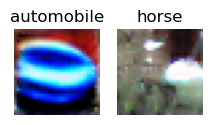

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

NUM_SEEDS = 20
SEED_TO_PREVIEW = 1
NUM_CLASSES = len(generated_dataset_config.class_captions)

generated_images = []

for subplot_i,i in enumerate(range(SEED_TO_PREVIEW,NUM_SEEDS*NUM_CLASSES,NUM_SEEDS)):
    plt.subplot(2, 5, subplot_i+1)
    plt.axis('off')
    plt.title(generated_dataset_config.dataset[i][generated_dataset_config.caption_column])
    plt.imshow(generated_dataset_config.dataset[i][generated_dataset_config.image_column])
    generated_images.append(generated_dataset_config.dataset[i][generated_dataset_config.image_column])

['automobile', 'horse']


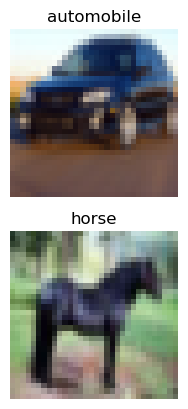

In [3]:
search_index = 0
prompts = train_dataset_config.class_captions
print(prompts)

for i in range(NUM_CLASSES):
    plt.subplot(2, NUM_CLASSES//2, i+1)
    plt.axis('off')

    #Train dataset is not in class order, so we will have to search
    prompt = prompts[i]
    search_index = 0
    while train_dataset_config.dataset[search_index][train_dataset_config.caption_column] != prompt:
        search_index += 1
    
    plt.title(train_dataset_config.dataset[search_index][train_dataset_config.caption_column])
    plt.imshow(train_dataset_config.dataset[search_index][train_dataset_config.image_column])

In [4]:
import torch

save_path = (
    project_config.PWD + f +
    "VAE" + f +
    f"vae-{dataset_type}.pt"
)
dataset_size = len(train_dataset_config.dataset)
pregenerated_vae_results = torch.load(save_path)
print(list(pregenerated_vae_results.shape))
pregenerated_vae_results = pregenerated_vae_results.reshape(dataset_size,4*4*4)

[5000, 4, 4, 4]


/tmp/ipykernel_760528/2447758324.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pregenerated_vae_results = torch.load(save_path)


Now generate attributions using cosine similarity on the DINOV2 feature maps

In [5]:
weight_dtype = torch.float32
dataset_length = len(train_dataset_config.dataset)

def calculate_VAE_Attribution(image, n):

    model_type = Model_Type_Enum.FULL
    model_config = Model_Config(
        project_config=project_config,
        MODEL_TYPE=model_type,
        DATASET_TYPE=dataset_type,
        NUM_CHECKPOINTS=10, 
        ITERATIONS_PER_CHECKPOINT=1000
    )

    p = model_config.getModelDirectory()
    _, _, vae, _ = model_config.loadModelComponents(p)

    if project_config.IS_CUDA:
        vae.to("cuda")

    vae.requires_grad_(False)
    print("") #Stop ipynb from dumping the full VAE description after this block

    rgb_image = image.convert("RGB")
    transformed_image = train_dataset_config.train_transforms(rgb_image)
    transformed_image = torch.stack([transformed_image])
    transformed_image = transformed_image.to(memory_format=torch.contiguous_format).float()
    print(transformed_image.shape)

    if project_config.IS_CUDA:
        example_batch = transformed_image.cuda()
    else:
        example_batch = transformed_image
    image = example_batch
    # Convert images to latent space
    latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
    latents = latents * vae.config.scaling_factor

    latents = latents.reshape(1,4*4*4)
    if project_config.IS_CUDA:
        latents = latents.detach().cpu()
    print(latents.shape)
    print(pregenerated_vae_results.shape)

    cosine_similarity = torch.nn.CosineSimilarity(dim=1)

    c = torch.zeros(1,dataset_length)

    set_size = 1000

    for i in range(0,dataset_length//set_size):
        a=i*set_size
        b=(i+1)*set_size

        c[0,a:b] = cosine_similarity(latents,pregenerated_vae_results[a:b])

    top_k = torch.topk(c,n)
    top_k_scores = torch.flatten(top_k.values)
    top_k_indicies = torch.flatten(top_k.indices)
    return top_k_indicies, top_k_scores

In [6]:
if RECALCULATE_ATTRIBUTION:
    TOP_N_IMAGES_TO_SHOW = 5
    top_n_indices = []
    top_n_scores = []
    for i in range(len(prompts)):
        top_n_i, top_n_s = calculate_VAE_Attribution(generated_images[i],TOP_N_IMAGES_TO_SHOW)
        top_n_indices.append(top_n_i)
        top_n_scores.append(top_n_s)


torch.Size([1, 3, 32, 32])
torch.Size([1, 64])
torch.Size([5000, 64])

torch.Size([1, 3, 32, 32])
torch.Size([1, 64])
torch.Size([5000, 64])


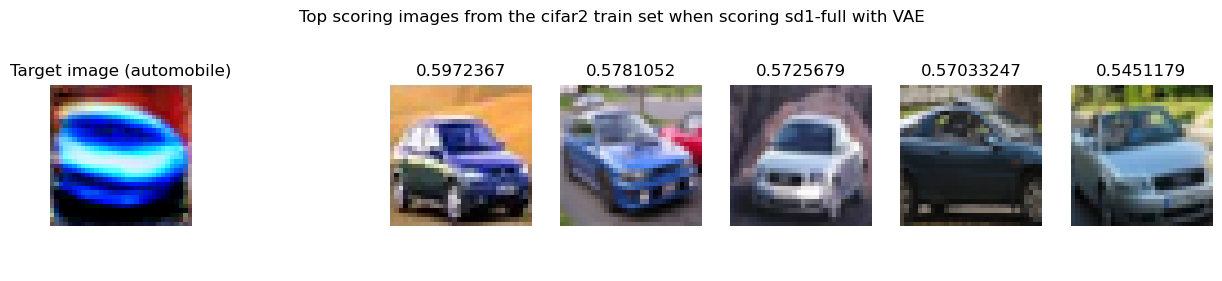

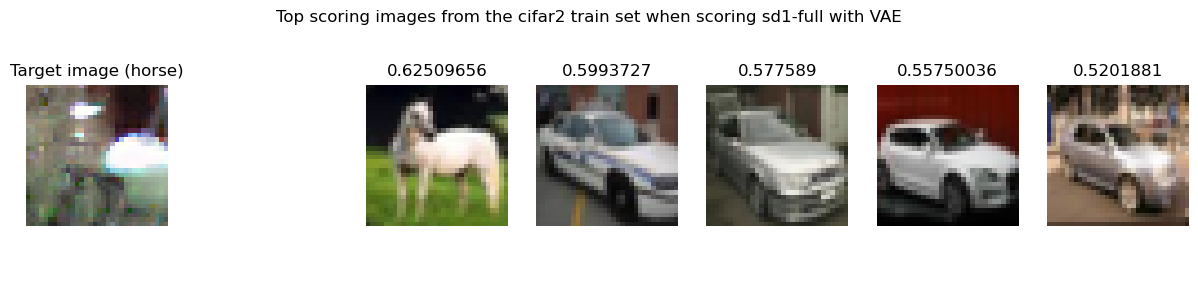

In [7]:
if RECALCULATE_ATTRIBUTION:
    for i in range(len(prompts)):
        fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
        fig.suptitle(f'Top scoring images from the {dataset_type} train set when scoring {MODEL_NAME_CLEAN} with VAE')
        
        axs[0].imshow(generated_images[i])
        
        axs[0].axis('off')
        axs[0].set_title('Target image' + " (" + prompts[i] + ")")
        axs[1].axis('off')
        
        for j in range(len(top_n_indices[i])):
            axs[j + 2].imshow(train_dataset_config.dataset[int(top_n_indices[i][j])]["image"])
            axs[j + 2].axis('off')
            axs[j + 2].set_title(str(top_n_scores[i][j].numpy()))

        fig.show()

## Counter Factuals
### 1. Generate counter factual dataset

In [8]:
from utils.dataset_utils import Dataset_Generator
cfds = Dataset_Generator(
    project_config=project_config,
    dataset_type=dataset_type,
)

In [9]:
prompts = train_dataset_config.class_captions

TARGET_CLASS: horse
TARGET_SEED: 1
TARGET_IMAGE: 1

torch.Size([1, 3, 32, 32])
torch.Size([1, 64])
torch.Size([5000, 64])


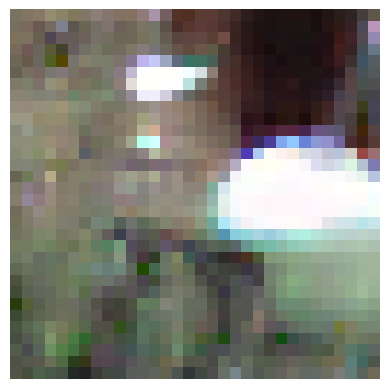

In [10]:
if dataset_type == Dataset_Type_Enum.CIFAR10:
    TARGET_CLASS = "frog"
if dataset_type == Dataset_Type_Enum.CIFAR2:
    TARGET_CLASS = "horse"

assert(TARGET_CLASS in prompts)
print(f"TARGET_CLASS: {TARGET_CLASS}")
print(f"TARGET_SEED: {SEED_TO_PREVIEW}")

TARGET_IMAGE = prompts.index(TARGET_CLASS) #Seed 1, frog
print(f"TARGET_IMAGE: {TARGET_IMAGE}")
plt.axis('off')
plt.imshow(generated_images[TARGET_IMAGE])

top_n_i, top_n_s = calculate_VAE_Attribution(generated_images[TARGET_IMAGE],1000)
top_n_i = top_n_i.numpy()

In [11]:
top_n_i_list = top_n_i.tolist()

Class conformity % (1): 100.0
Class conformity % (10): 40.0
Class conformity % (100): 59.0
Class conformity % (1000): 49.7


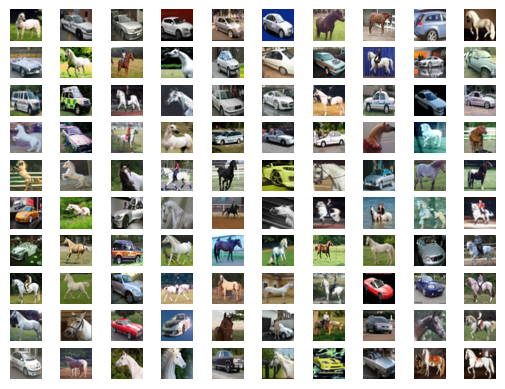

In [12]:
one_class_conformity = 0
ten_class_conformity = 0
hundred_class_conformity = 0
thousand_class_conformity = 0
num_images_per_axis = 10

for i in range(len(top_n_i_list)):
    if train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.caption_column] == TARGET_CLASS:
        if i<1:
            one_class_conformity += 1
        if i<10:
            ten_class_conformity += 1
        if i<100:
            hundred_class_conformity += 1
        if i<1000:
            thousand_class_conformity += 1
    
one_class_conformity_percentage = (one_class_conformity/1)*100
print(f"Class conformity % (1): {one_class_conformity_percentage}")
ten_class_conformity_percentage = (ten_class_conformity/10)*100
print(f"Class conformity % (10): {ten_class_conformity_percentage}")
hundred_class_conformity_percentage = (hundred_class_conformity/100)*100
print(f"Class conformity % (100): {hundred_class_conformity_percentage}")
thousand_class_conformity_percentage = (thousand_class_conformity/1000)*100
print(f"Class conformity % (1000): {thousand_class_conformity_percentage}")

for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])


In [13]:
counter_factual_model_name = f"VAE_{MODEL_NAME_CLEAN}_{TARGET_CLASS}_seed_{SEED_TO_PREVIEW}"

cfds.create_counterfactual_config(counter_factual_model_name,top_n_i_list)

Config VAE_sd1-full_horse_seed_1 already exists!


False

In [14]:
print(counter_factual_model_name)

VAE_sd1-full_horse_seed_1


In [15]:
from counter_factuals.counter_factuals_utils import Counter_Factual_Image_Generator

In [16]:
cfig = Counter_Factual_Image_Generator(
    project_config=project_config,
    counter_factual_model_name=counter_factual_model_name,
    model_type=model_type,
    dataset_type=dataset_type,
)

image = cfig.generate_counter_factual_image(
    seed=SEED_TO_PREVIEW,
    image_class=TARGET_CLASS,
    save_image=True,
    prompts=prompts,
)

plt.axis('off')
plt.imshow(image)

AssertionError: 